
======= Proses Gambar: 142_jpg.rf.6e227599721aa3921ac5bc0f57153f6f.jpg =======


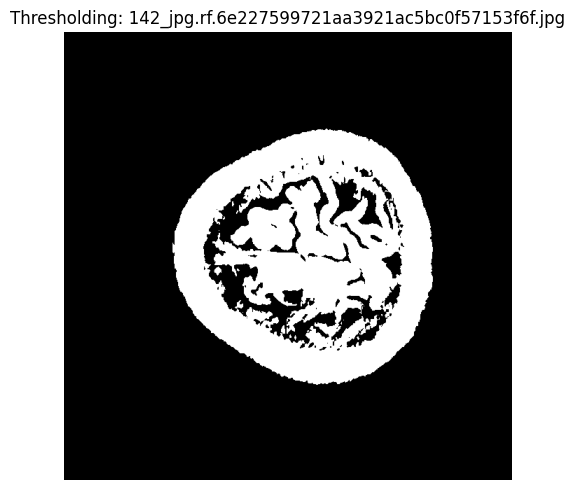

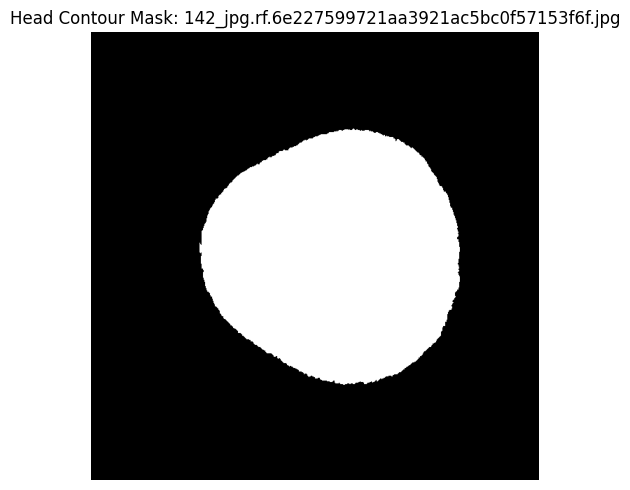

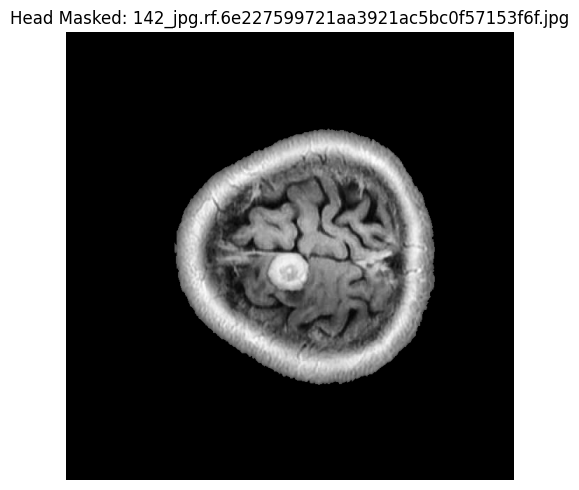

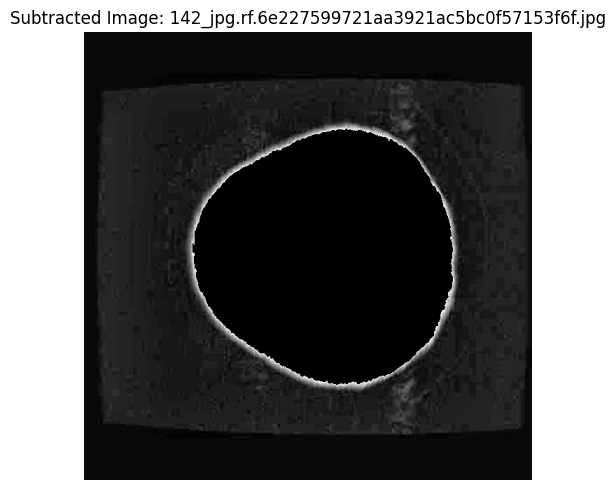

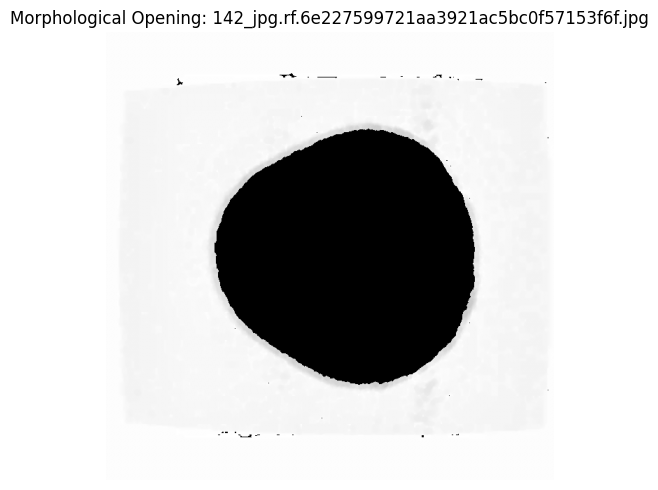

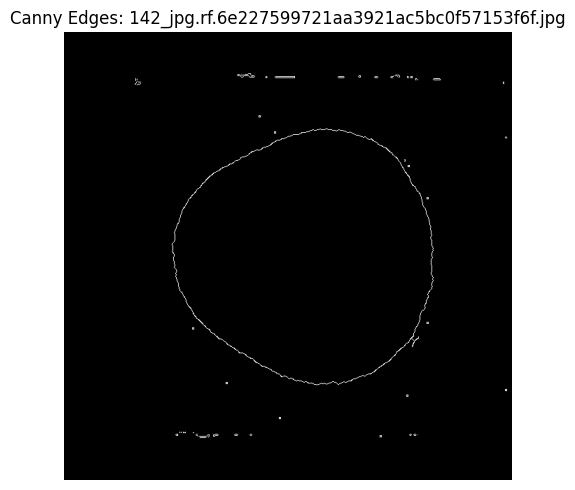

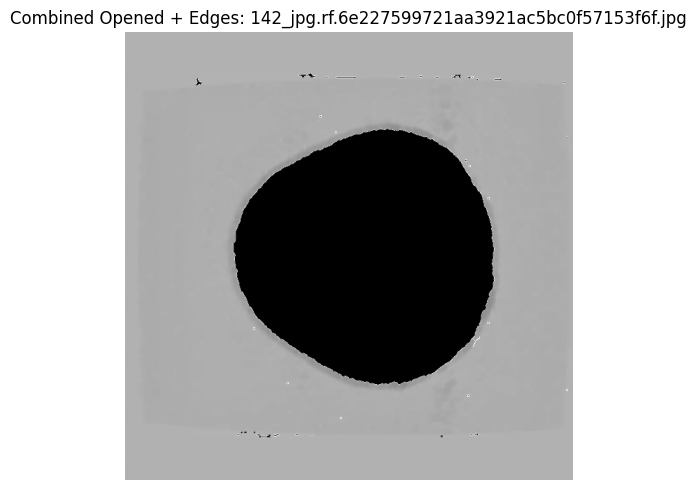

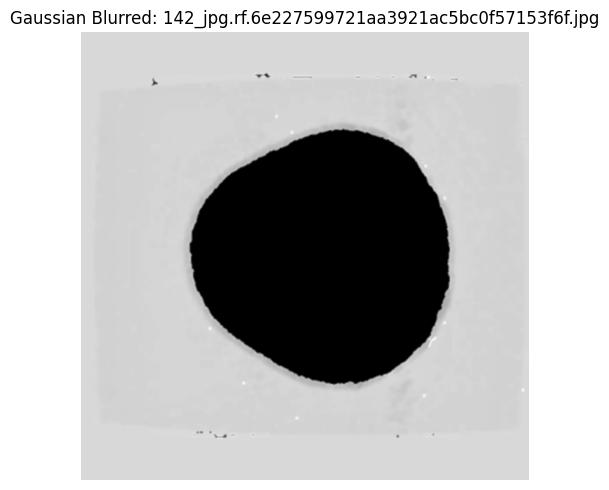

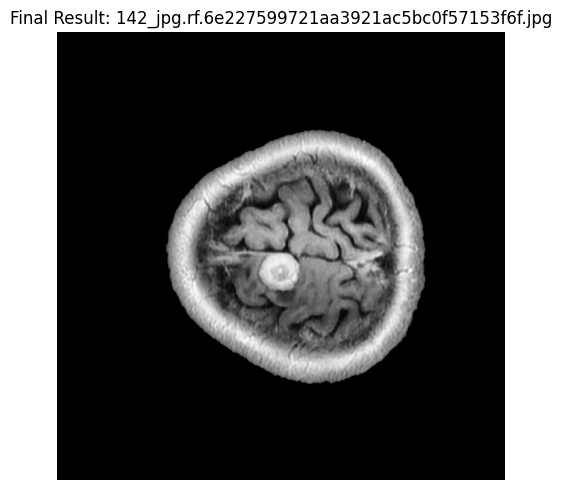

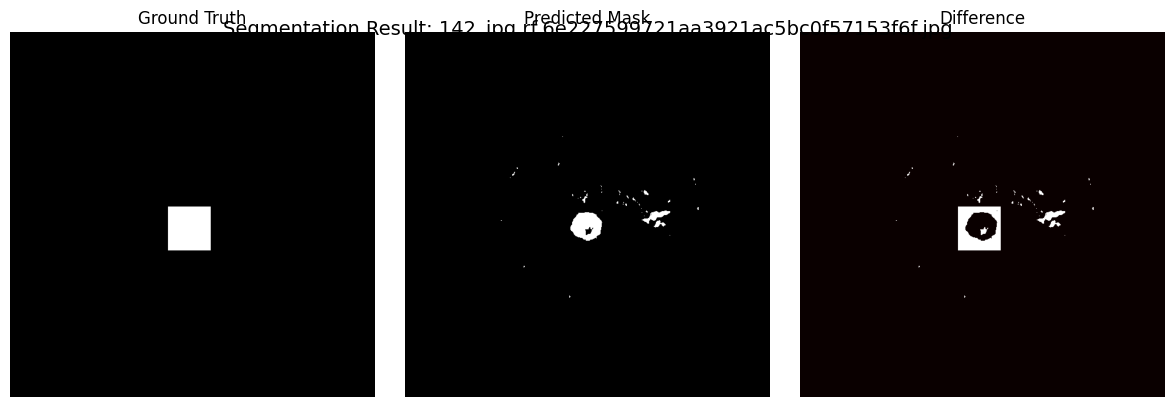

IoU: 0.2999, Precision: 0.7029, Recall: 0.3434, Dice: 0.4614
Hausdorff Distance: 163.51, CCR: 0.9887, Runtime: 1.46s

======= Proses Gambar: 143_jpg.rf.d219d311fe10a51de69aa44520962deb.jpg =======


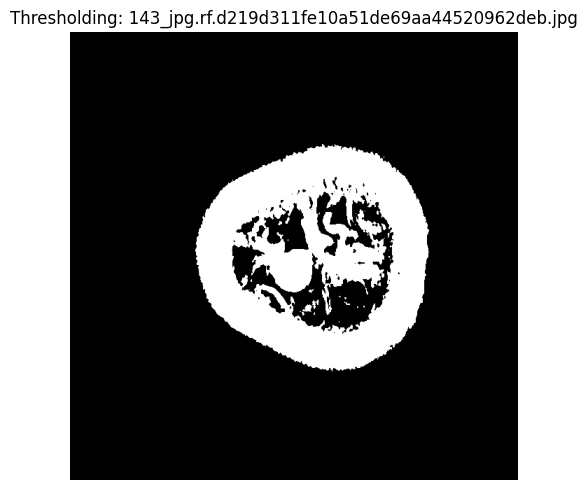

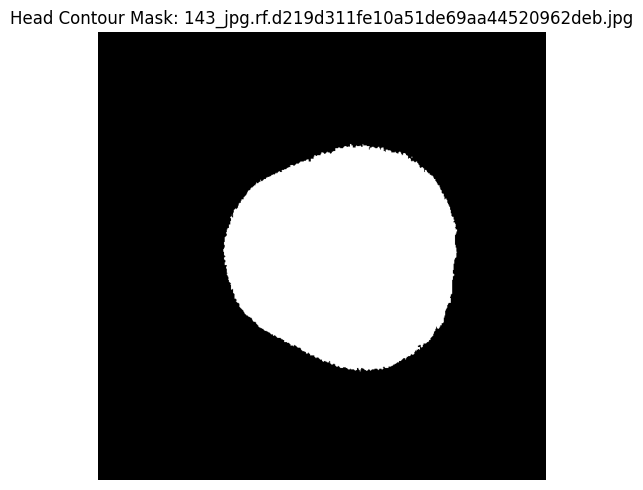

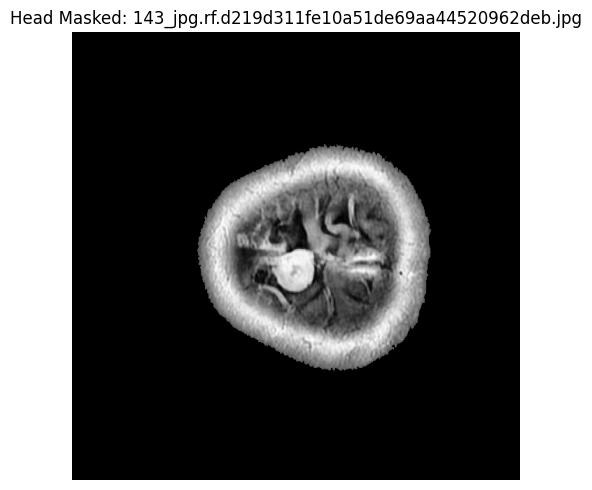

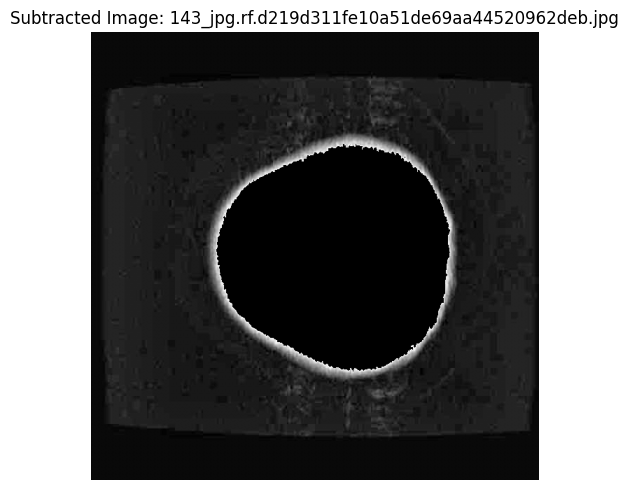

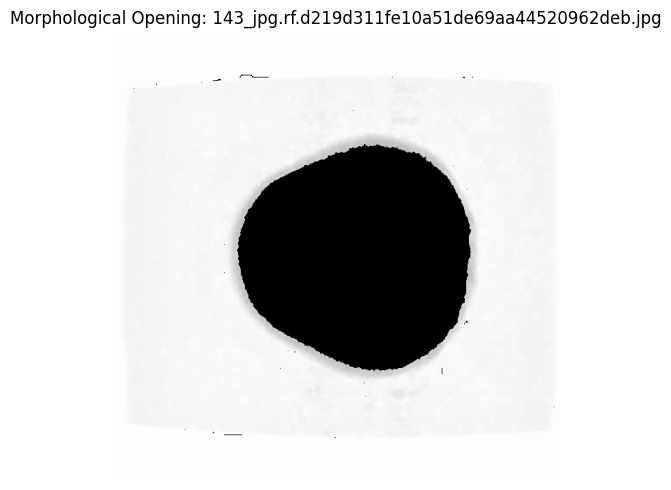

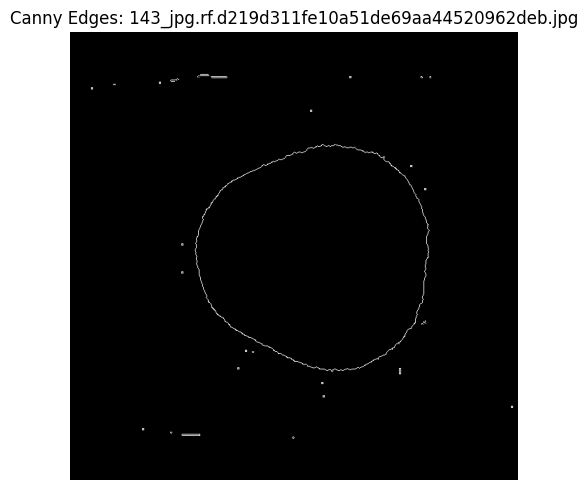

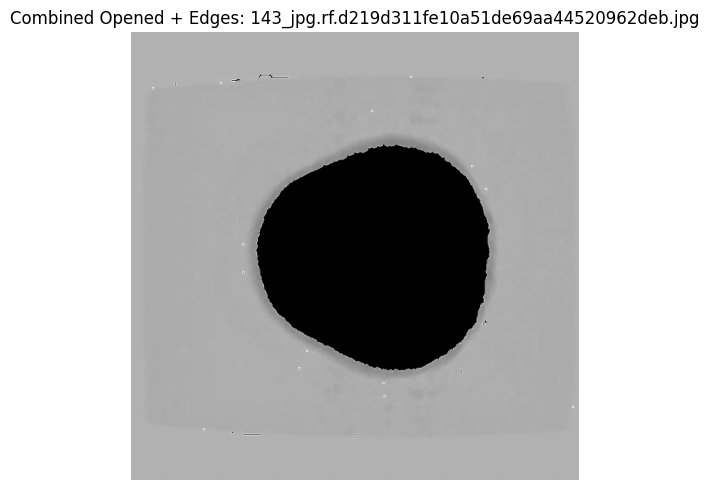

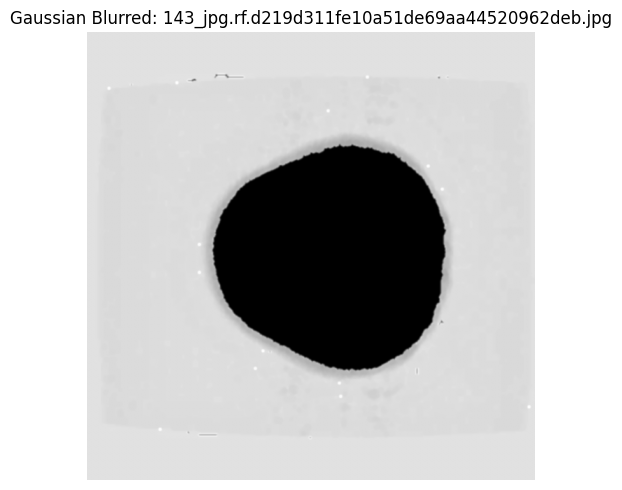

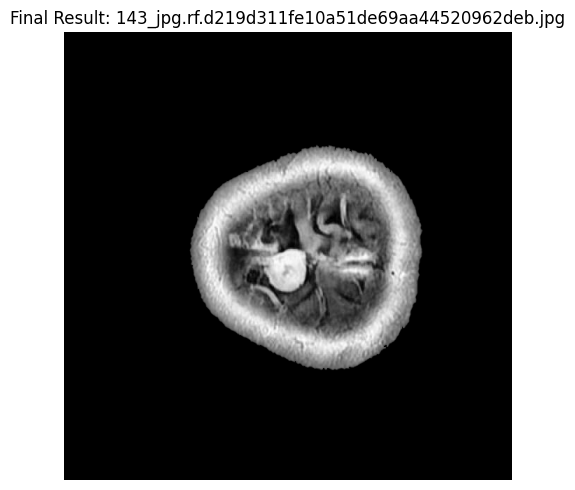

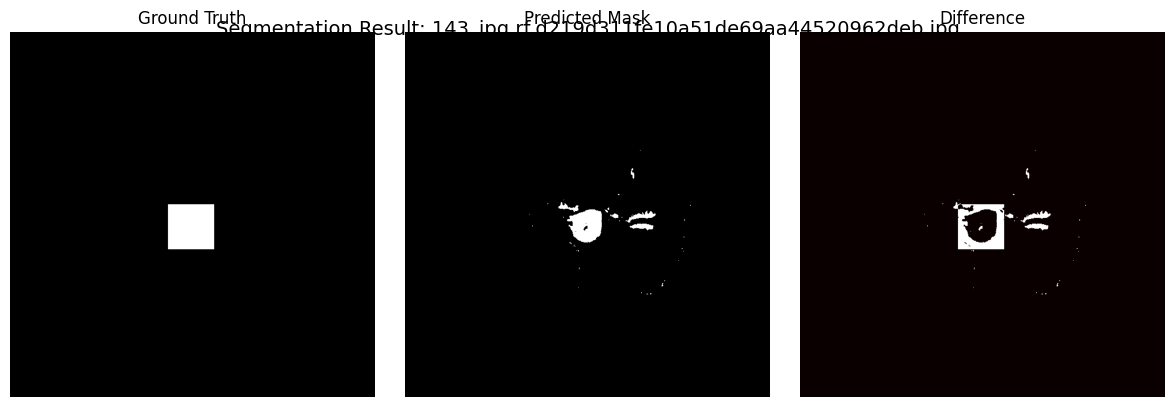

IoU: 0.3794, Precision: 0.7469, Recall: 0.4354, Dice: 0.5501
Hausdorff Distance: 143.00, CCR: 0.9889, Runtime: 1.51s

======= Proses Gambar: 158_jpg.rf.43ffbf7b28796fda4d326005beaa8303.jpg =======


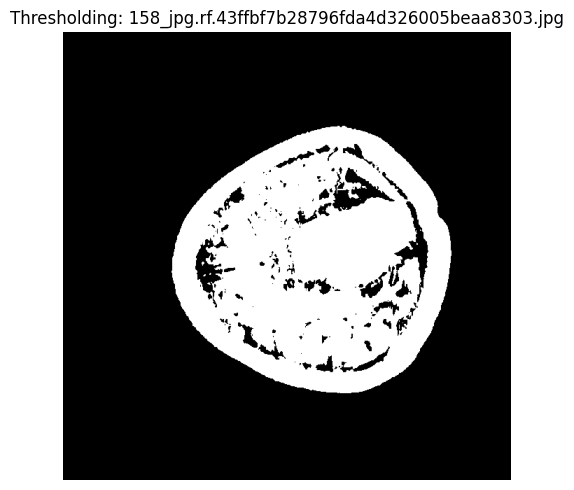

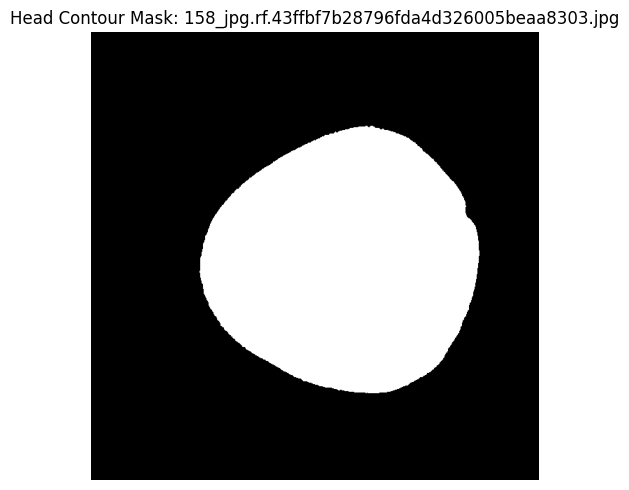

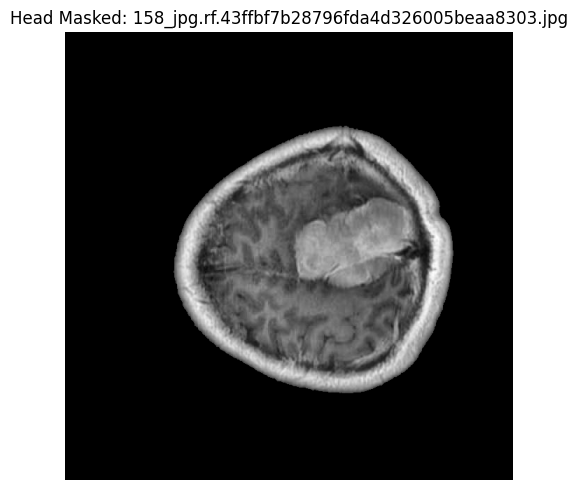

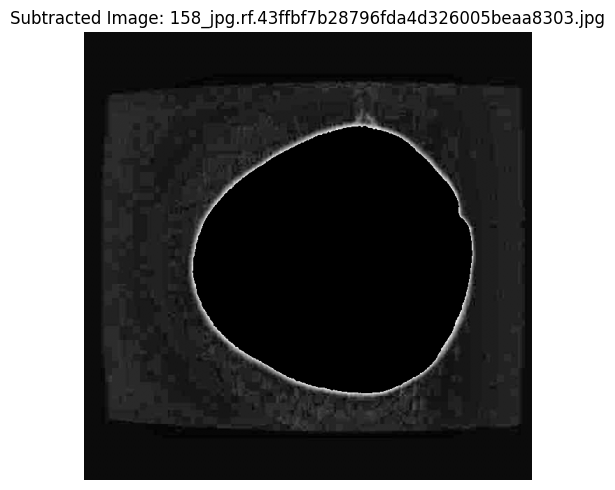

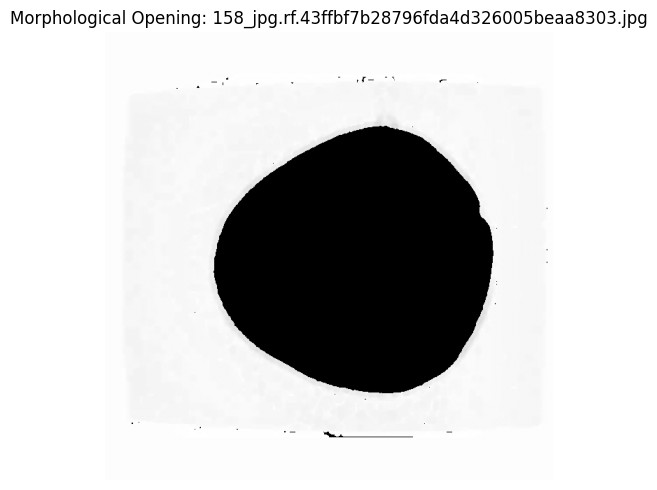

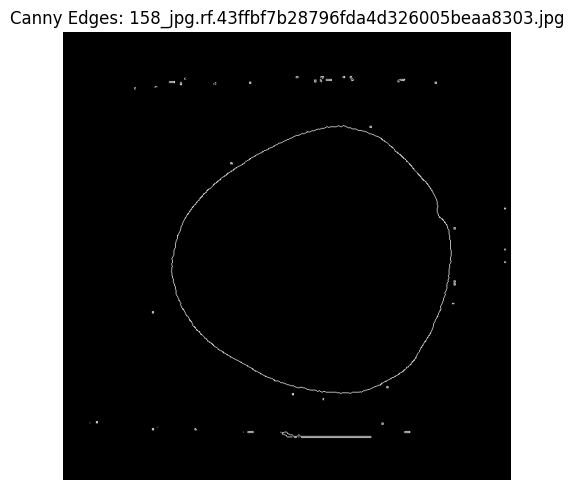

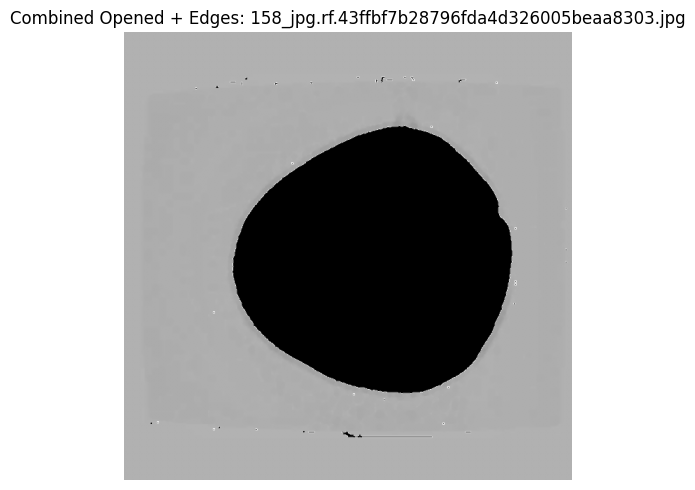

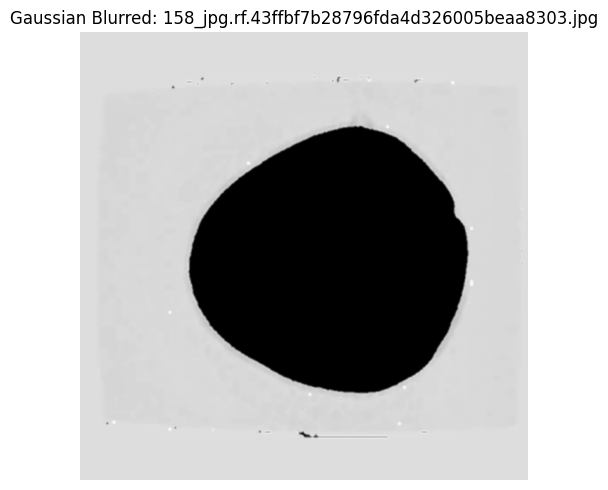

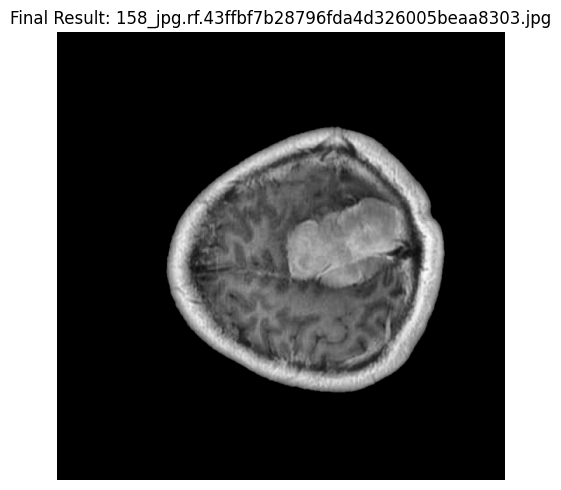

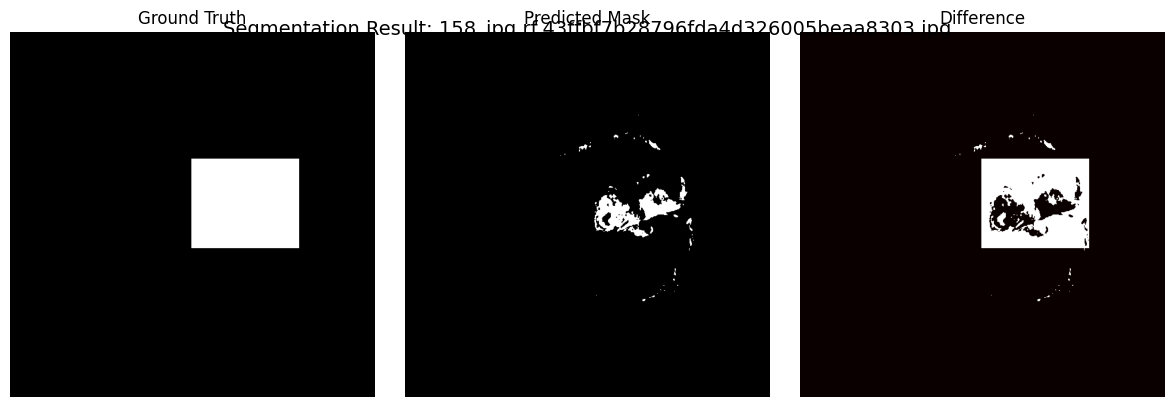

IoU: 0.1888, Precision: 0.9394, Recall: 0.1911, Dice: 0.3176
Hausdorff Distance: 93.00, CCR: 0.9405, Runtime: 1.41s

======= Proses Gambar: 180_jpg.rf.8fcc2c29568483b33ff769d2e1fe89ff.jpg =======


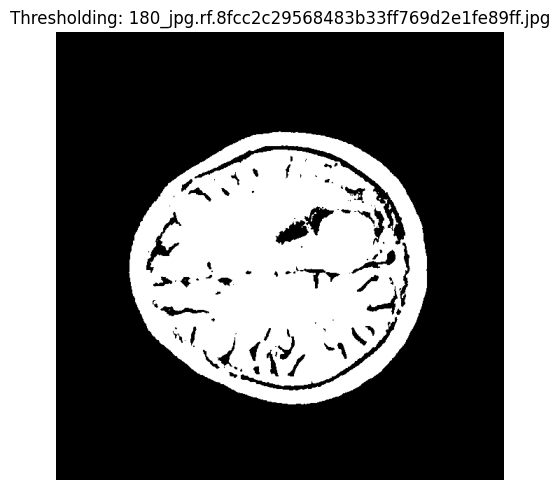

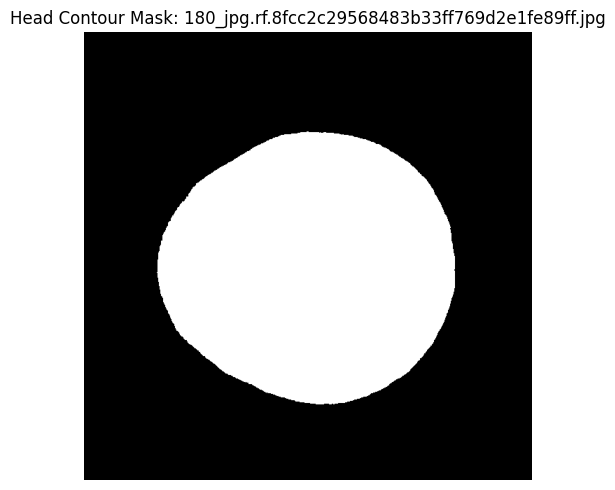

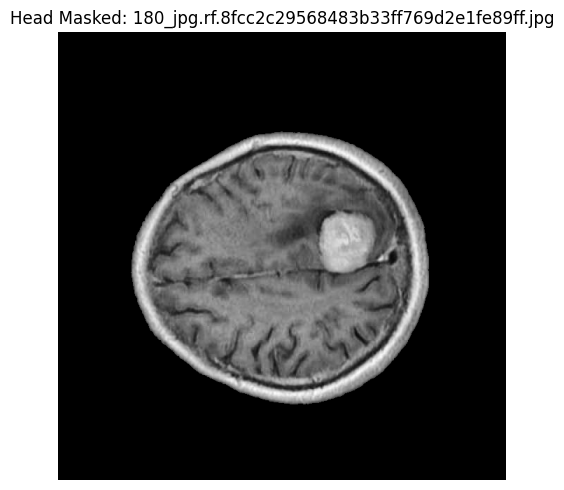

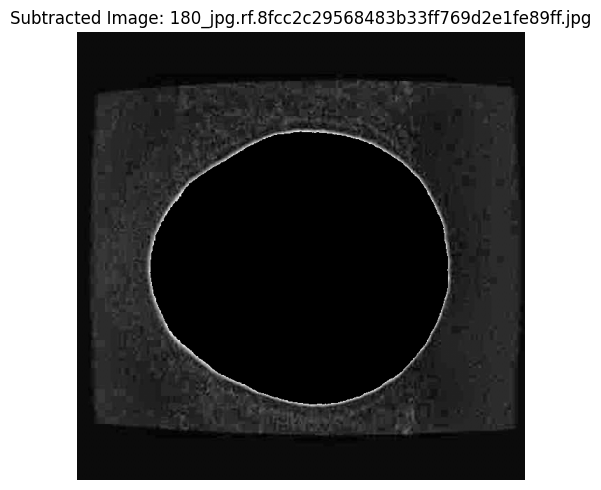

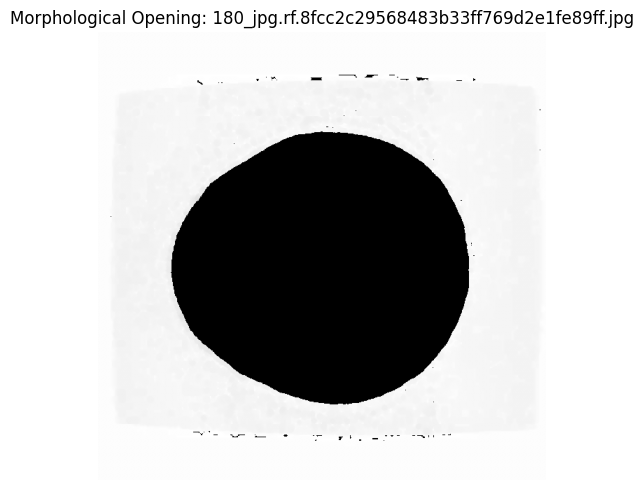

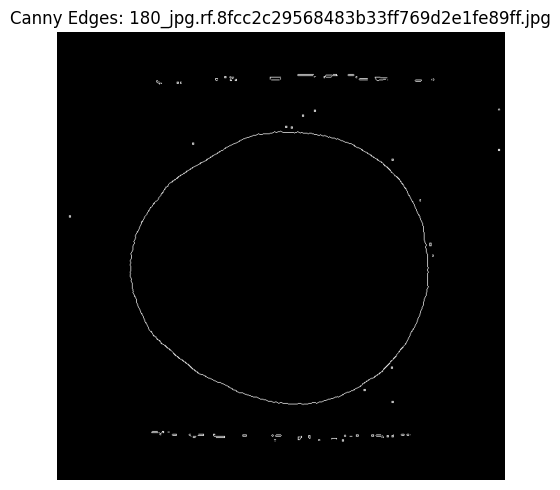

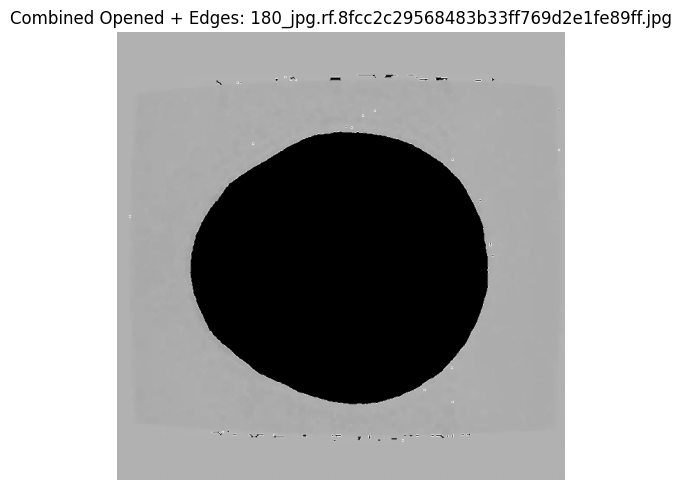

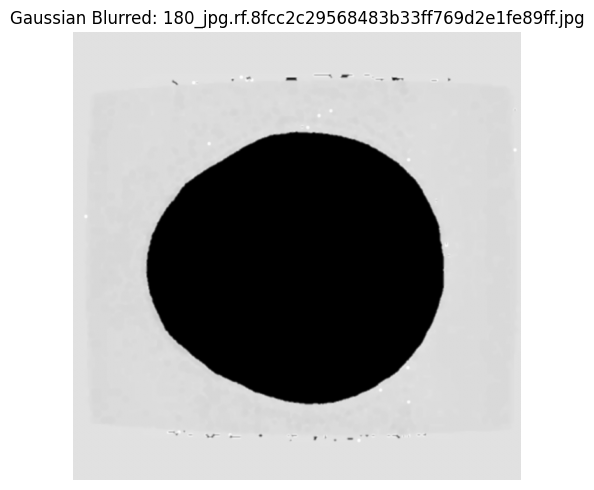

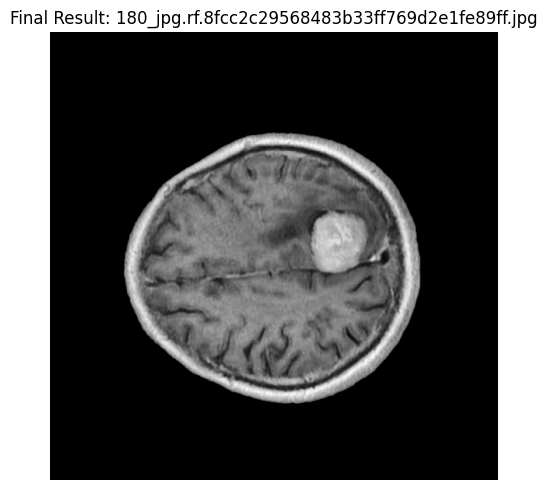

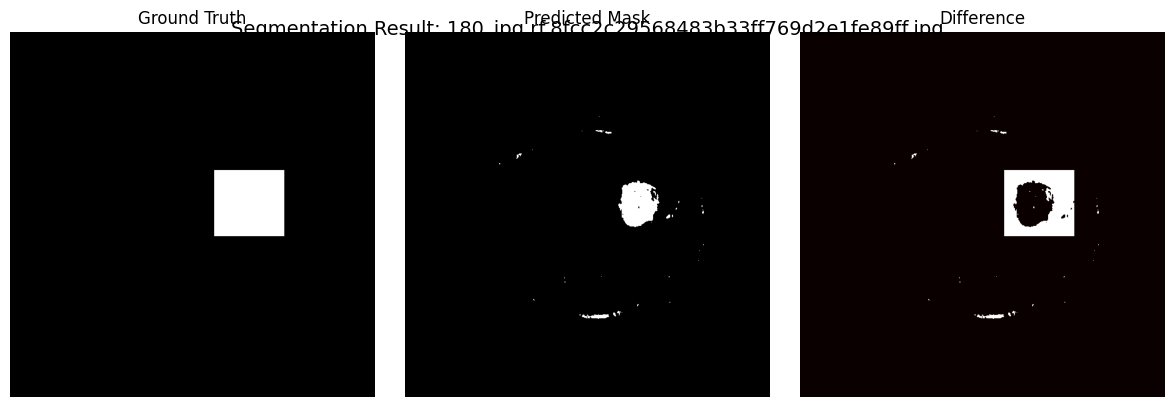

IoU: 0.2809, Precision: 0.9016, Recall: 0.2897, Dice: 0.4386
Hausdorff Distance: 193.37, CCR: 0.9742, Runtime: 1.38s

======= Proses Gambar: 203_jpg.rf.91299ef71ec075409732aae89bbc99a7.jpg =======


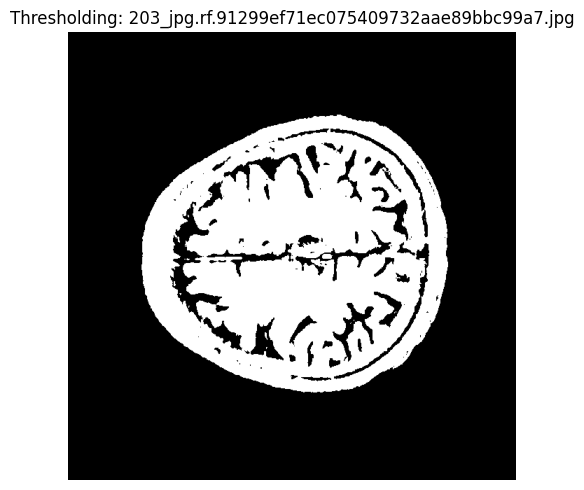

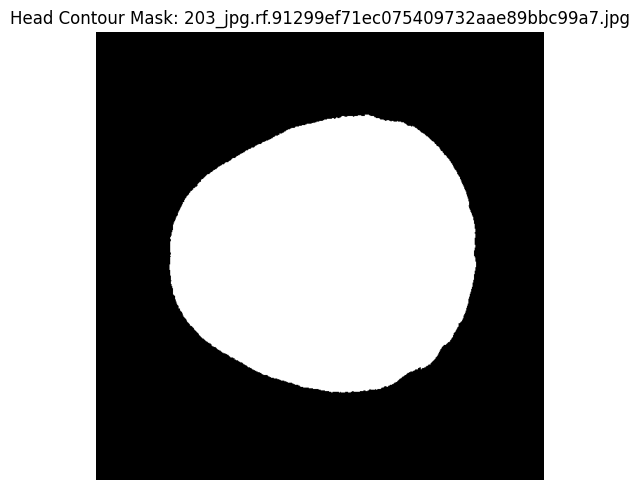

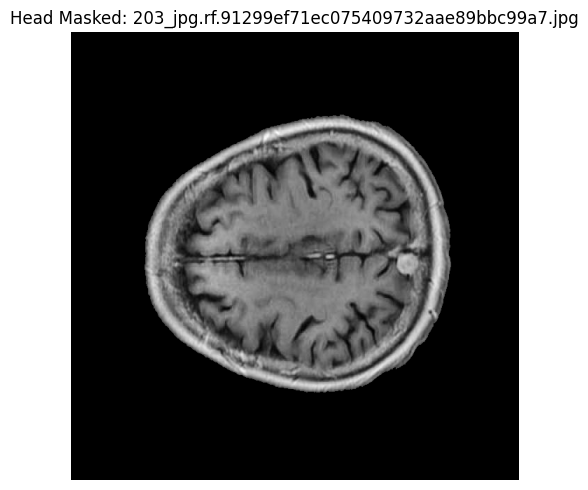

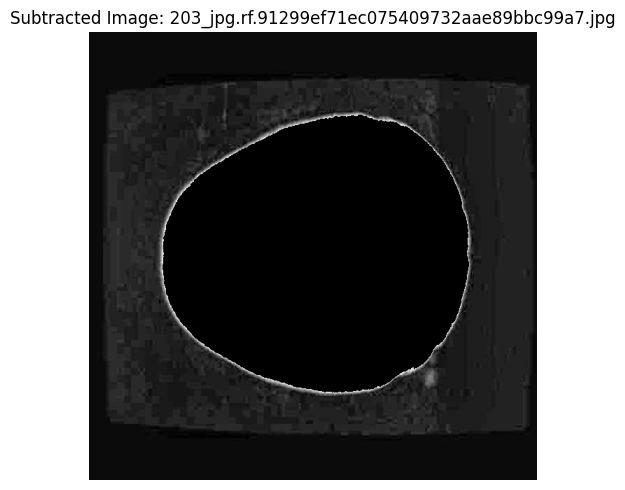

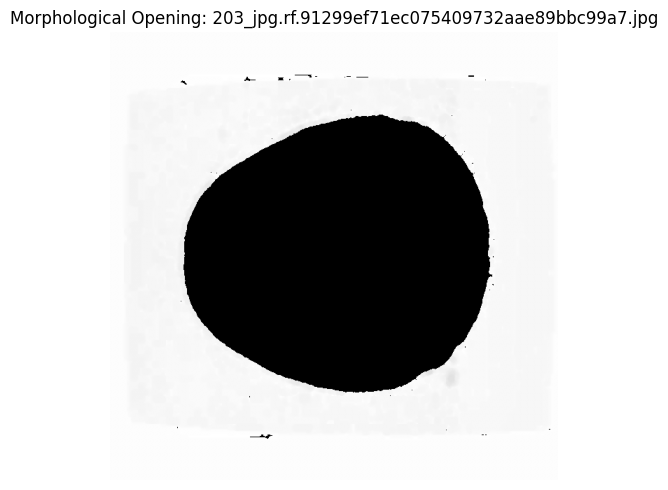

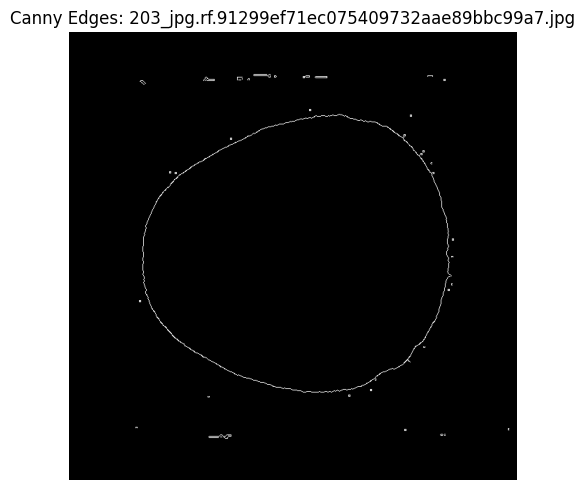

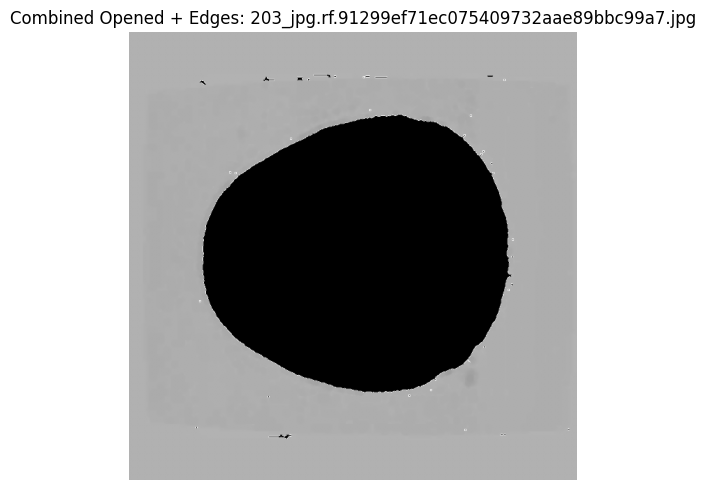

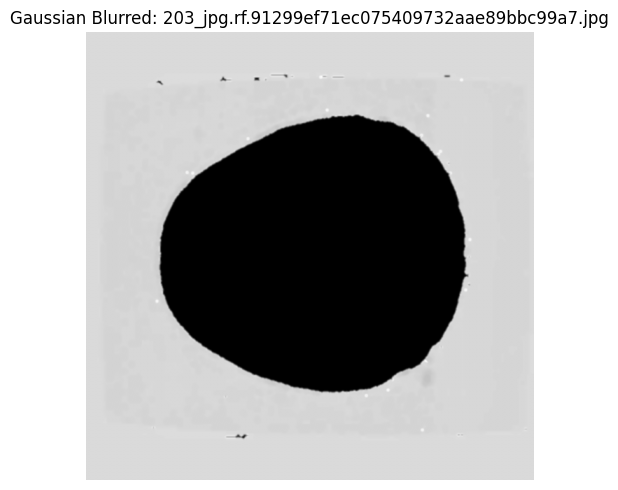

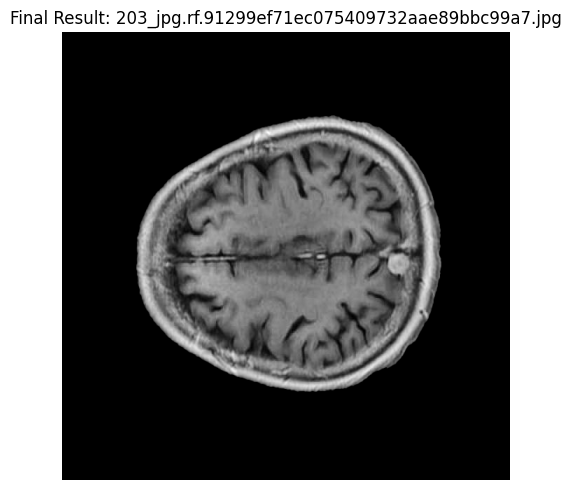

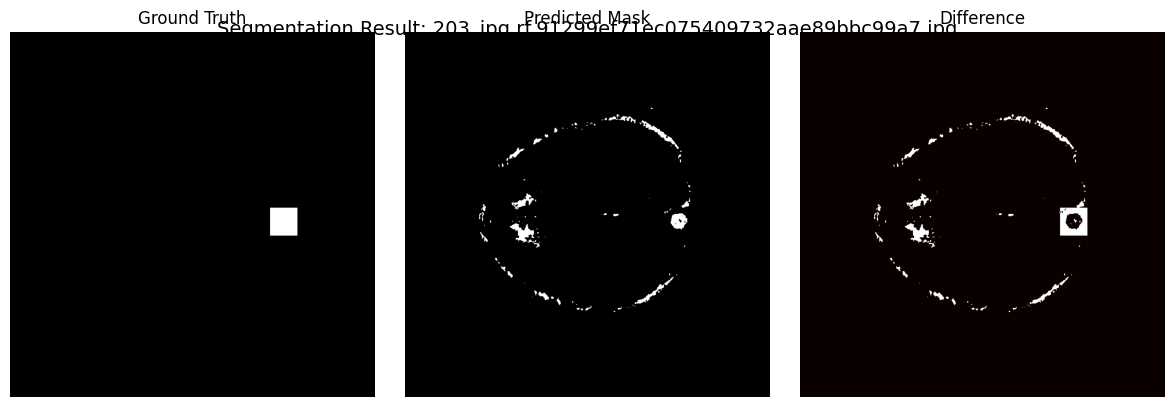

IoU: 0.1033, Precision: 0.1477, Recall: 0.2560, Dice: 0.1873
Hausdorff Distance: 326.00, CCR: 0.9872, Runtime: 1.56s

=== Ringkasan Evaluasi Segmentasi ===
Rata-rata IoU         : 0.2504
Rata-rata Precision   : 0.6877
Rata-rata Recall      : 0.3031
Rata-rata Dice        : 0.3910
Rata-rata Hausdorff   : 183.7774
Rata-rata CCR         : 0.9759
Rata-rata Runtime     : 1.4647 detik


In [4]:
import os
import cv2
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.morphology import opening, disk
from sklearn.metrics import jaccard_score, precision_score, recall_score, confusion_matrix
from scipy.spatial.distance import directed_hausdorff
from skimage import measure
from collections import defaultdict

folder_path = r"C:/Users/naufa/OneDrive/Desktop/SEMESTER 4/PCD/PCD/Testing"
annotation_file = r"C:/Users/naufa/OneDrive/Desktop/SEMESTER 4/PCD/PCD/_annotations.coco.json"

with open(annotation_file) as f:
    coco = json.load(f)

file_to_id = {img["file_name"]: img["id"] for img in coco["images"]}
ann_by_image_id = defaultdict(list)
for ann in coco["annotations"]:
    ann_by_image_id[ann["image_id"]].append(ann)

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
image_files = image_files[:5] 

def preprocess_and_visualize(img, image_name):
    stages = {}

    def show(title, img_to_show):
        plt.figure(figsize=(5, 5))
        plt.imshow(img_to_show, cmap='gray')
        plt.title(f"{title}: {image_name}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    stages['thresholding'] = thresh
    show('Thresholding', thresh)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, 255, -1)
    stages['head_contour_mask'] = mask
    show('Head Contour Mask', mask)

    head = cv2.bitwise_and(img, img, mask=mask)
    stages['head_masked'] = head
    show('Head Masked', head)

    subtracted = cv2.subtract(img, head)
    stages['subtracted'] = subtracted
    show('Subtracted Image', subtracted)

    opened = opening(subtracted, disk(3))
    opened = (opened * 255).astype(np.uint8)
    stages['morph_opening'] = opened
    show('Morphological Opening', opened)

    edges = cv2.Canny(opened, 50, 150)
    stages['edges'] = edges
    show('Canny Edges', edges)

    combined = cv2.addWeighted(opened, 0.7, edges, 0.3, 0)
    stages['combined'] = combined
    show('Combined Opened + Edges', combined)

    blurred = cv2.GaussianBlur(combined, (5, 5), sigmaX=1)
    stages['blurred'] = blurred
    show('Gaussian Blurred', blurred)

    result = cv2.subtract(head, blurred)
    stages['final_result'] = result
    show('Final Result', result)

    return result

def em_segment(preprocessed_img, k=4, max_area_ratio=0.02):
    img_flattened = preprocessed_img.flatten().reshape(-1, 1)
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(img_flattened)
    labels = gmm.predict(img_flattened)
    mask = labels.reshape(preprocessed_img.shape)

    means = gmm.means_.flatten()
    white_label = np.argmax(means)

    binary_mask = np.zeros_like(mask, dtype=np.uint8)
    binary_mask[mask == white_label] = 255

    labeled_mask = measure.label(binary_mask, connectivity=2)
    props = measure.regionprops(labeled_mask)

    image_area = preprocessed_img.shape[0] * preprocessed_img.shape[1]
    tumor_only_mask = np.zeros_like(binary_mask)
    for prop in props:
        if prop.area < image_area * max_area_ratio:
            tumor_only_mask[labeled_mask == prop.label] = 255

    return tumor_only_mask, props, image_area

def create_ground_truth_mask(image_id, shape):
    anns = ann_by_image_id[image_id]
    mask = np.zeros(shape, dtype=np.uint8)
    for ann in anns:
        if 'segmentation' in ann:
            for polygon in ann['segmentation']:
                pts = np.array(polygon).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [pts], color=255)
    return mask

def calculate_ccr(gt_bin, pred_bin):
    tn, fp, fn, tp = confusion_matrix(gt_bin, pred_bin, labels=[0, 1]).ravel()
    return (tp + tn) / (tp + tn + fp + fn)

def evaluate_segmentation(gt_mask, pred_mask):
    gt_bin = gt_mask.flatten() > 0
    pred_bin = pred_mask.flatten() > 0

    iou = jaccard_score(gt_bin, pred_bin)
    precision = precision_score(gt_bin, pred_bin)
    recall = recall_score(gt_bin, pred_bin)
    intersection = np.logical_and(gt_bin, pred_bin).sum()
    dice = (2. * intersection) / (gt_bin.sum() + pred_bin.sum())
    gt_coords = np.argwhere(gt_mask > 0)
    pred_coords = np.argwhere(pred_mask > 0)
    hausdorff = directed_hausdorff(pred_coords, gt_coords)[0]
    ccr = calculate_ccr(gt_bin, pred_bin)

    return iou, precision, recall, dice, hausdorff, ccr

results = []
runtimes = []

for image_file in image_files:
    print(f"\n======= Proses Gambar: {image_file} =======")
    image_path = os.path.join(folder_path, image_file)
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if gray is None:
        print(f"❌ Gagal membaca gambar {image_file}")
        continue

    image_id = file_to_id[image_file]
    gt_mask = create_ground_truth_mask(image_id, gray.shape)

    preprocessed = preprocess_and_visualize(gray, image_file)

    start = time.time()
    tumor_mask, props, image_area = em_segment(preprocessed)
    duration = time.time() - start
    runtimes.append(duration)

    # Tampilkan hasil
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(tumor_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    diff = cv2.absdiff(gt_mask, tumor_mask)
    plt.imshow(diff, cmap='hot')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Segmentation Result: {image_file}", fontsize=14)
    plt.show()

    iou, precision, recall, dice, hausdorff, ccr = evaluate_segmentation(gt_mask, tumor_mask)
    results.append((image_file, iou, precision, recall, dice, hausdorff, ccr))
    print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Dice: {dice:.4f}")
    print(f"Hausdorff Distance: {hausdorff:.2f}, CCR: {ccr:.4f}, Runtime: {duration:.2f}s")

ious, precisions, recalls, dices, hausdorffs, ccrs = zip(*[r[1:] for r in results])
print("\n=== Ringkasan Evaluasi Segmentasi ===")
print(f"Rata-rata IoU         : {np.mean(ious):.4f}")
print(f"Rata-rata Precision   : {np.mean(precisions):.4f}")
print(f"Rata-rata Recall      : {np.mean(recalls):.4f}")
print(f"Rata-rata Dice        : {np.mean(dices):.4f}")
print(f"Rata-rata Hausdorff   : {np.mean(hausdorffs):.4f}")
print(f"Rata-rata CCR         : {np.mean(ccrs):.4f}")
print(f"Rata-rata Runtime     : {np.mean(runtimes):.4f} detik")